In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import sys
import torch
import os, pickle
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import contextily as cx
import sklearn
from census import Census
import sys, os
import numpy as np
sys.path.append('../dataset/safegraph/')
sys.path.append('../train')
from models import *
from dataset_classes import*
from helper_funcs import *

root = '/mnt/e/julia/regional-representations-graph-model/'
scenario = 'all_valid_data/'#'highres_landsat_experiment/' #'all_valid_data/'
savedir=root +  f'train/outputs/{scenario}evaluate/'
if not os.path.exists(savedir):
    createCleanDir(savedir)

# read in embeddings
node_list_path = root + f'dataset/preprocessed_data/{scenario}node_list.csv'
node_list = pd.read_csv(node_list_path, dtype={'GEOID': str})
num_nodes = node_list.shape[0]
idx_node_map = dict(zip(node_list.index, node_list['GEOID']))
node_idx_map = dict(zip(node_list['GEOID'], node_list.index))

search = root + f'train/outputs/{scenario}distance/'
if os.path.exists(search):
    for f in os.listdir(search):
        if 'last.tar' in f:
            pre_trained = search + f
            break
            

checkpoint=torch.load(pre_trained)
model = NodeEmbeddings(num_nodes, embedding_dim=200)
model.load_state_dict(checkpoint['model_state_dict'],strict=False)

<All keys matched successfully>

# Plot tracts

In [2]:
#      Read in Tract shapefiles
tract_data_dir = root + 'dataset/Tracts/nyc_metro_boundaries/nyc_metro_boundaries.shp'
geodf = gpd.read_file(tract_data_dir)
geodf.rename(columns={'GEOID_TRAC': 'GEOID'}, inplace=True)  
geodf = geodf[['GEOID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'geometry']] 
def plot_list_geoids(geoid=None, df=None, col=None):
    if geoid is None:
        df_select = geodf
    else:
        df_select = geodf.loc[geodf.GEOID.isin(geoid)]
    
    if col == None:
        ax = df_select.plot(figsize=(20,10))
    else:
        temp = df_select.merge(df[['GEOID', col]], on='GEOID', how='left')
        ax = temp.plot(column=col, legend=True, figsize=(20,10)) #  palette=plt.colormaps['GnBu']
        
    cx.add_basemap(ax, crs=df_select.crs.to_string())
    plt.title(f'{scenario} - {col}')
    # minx, miny, maxx, maxy = df_select.total_bounds
    # ax.set_xlim(minx, maxx)
    # ax.set_ylim(miny, maxy)

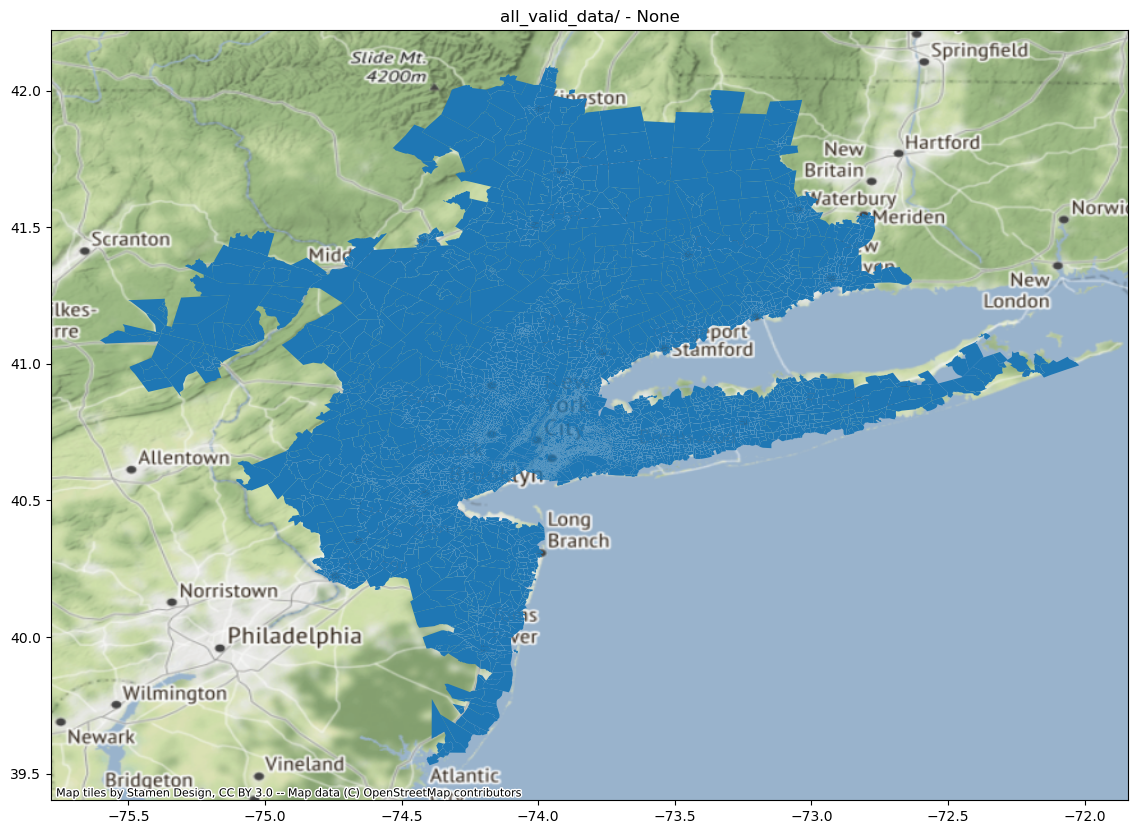

In [3]:
plot_list_geoids()

# Visualize Embeddings

Get census attributes per tract.

In [4]:
from census import Census

with open(root + 'dataset/api_keys/census_key.txt', 'r') as f:
    key = f.readline()
c = Census(key)

state_fps = ['42', '34', '36','25']

var = ['NAME', 'B01001_001E', 'B01001_026E', 'B01001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E', 'B02001_007E', 
        'B01001H_001E', 'B01001I_001E', 'B01002_001E', 'B19013_001E', 'B19083_001E', 'B27001_001E', 
        'B08101_009E', 'B08101_017E', 'B08101_025E', 'B08101_033E', 'B08101_049E', 'B15003_017E',
           'B15003_022E', 'B15003_023E', 'B15003_025E']

name = ['NAME', 'total_pop',  'num_women', 'num_men', 'total_black', 'total_na', 'total_asian', 'total_paisl', 
        'total_other', 'total_white', 'total_latino', 'total_median_age', 'median_household_income', 
        'income_gini_index', 'health_insurance_coverage', 'num_drive_alone', 
        'num_carpool', 'num_public_transit', 'num_walk', 'num_wfh', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree']

name_compute_ratio = ['num_women', 'num_men', 'total_black', 'total_na', 'total_asian', 'total_paisl', 'total_other', 'total_white', 'total_latino', 'health_insurance_coverage', 
                      'num_drive_alone', 'num_carpool', 'num_public_transit', 'num_walk', 'num_wfh', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree']

cols = name + ['state', 'county', 'tract']
census_df = pd.DataFrame(columns=cols)
for state in state_fps:
    census = c.acs5.state_county_tract(fields = var,
                                        state_fips = state,
                                        county_fips = '*',
                                        tract = "*",
                                        year = 2020)
    
    d = pd.DataFrame(census)
    d.rename(columns=dict(zip(var, name)), inplace=True)
    for col in name_compute_ratio:
        d[col] = d[col]/d['total_pop']
        
    # combine embeddings with labels
    d['GEOID'] = d['state'].astype(str) + d['county'].astype(str) + d['tract'].astype(str)
        
    census_df = pd.concat([census_df, d])

In [5]:
# add GEOID column to embeddings df
df = pd.DataFrame(checkpoint['model_state_dict']['node_embeddings.weight'].cpu())
df['GEOID'] = [idx_node_map[i] for i in df.index]
df = df.merge(census_df.drop(columns=['NAME']), on='GEOID')

# UMAP Clustering

In [6]:
import umap

In [7]:
import numba
@numba.njit()
def torch_distance(x, y):
    print('hello he;;p')
    out = torch.nn.functional.pairwise_distance(x, y, p=2.0)
    return out

In [9]:
# create a single dataframe so viz is the same
valid = df.copy()
for a, col in enumerate(['median_household_income','income_gini_index', 'num_wfh', 'num_public_transit', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree', 'total_median_age', 
                       'num_drive_alone']):
    
    valid = valid.loc[valid[col] > 0]

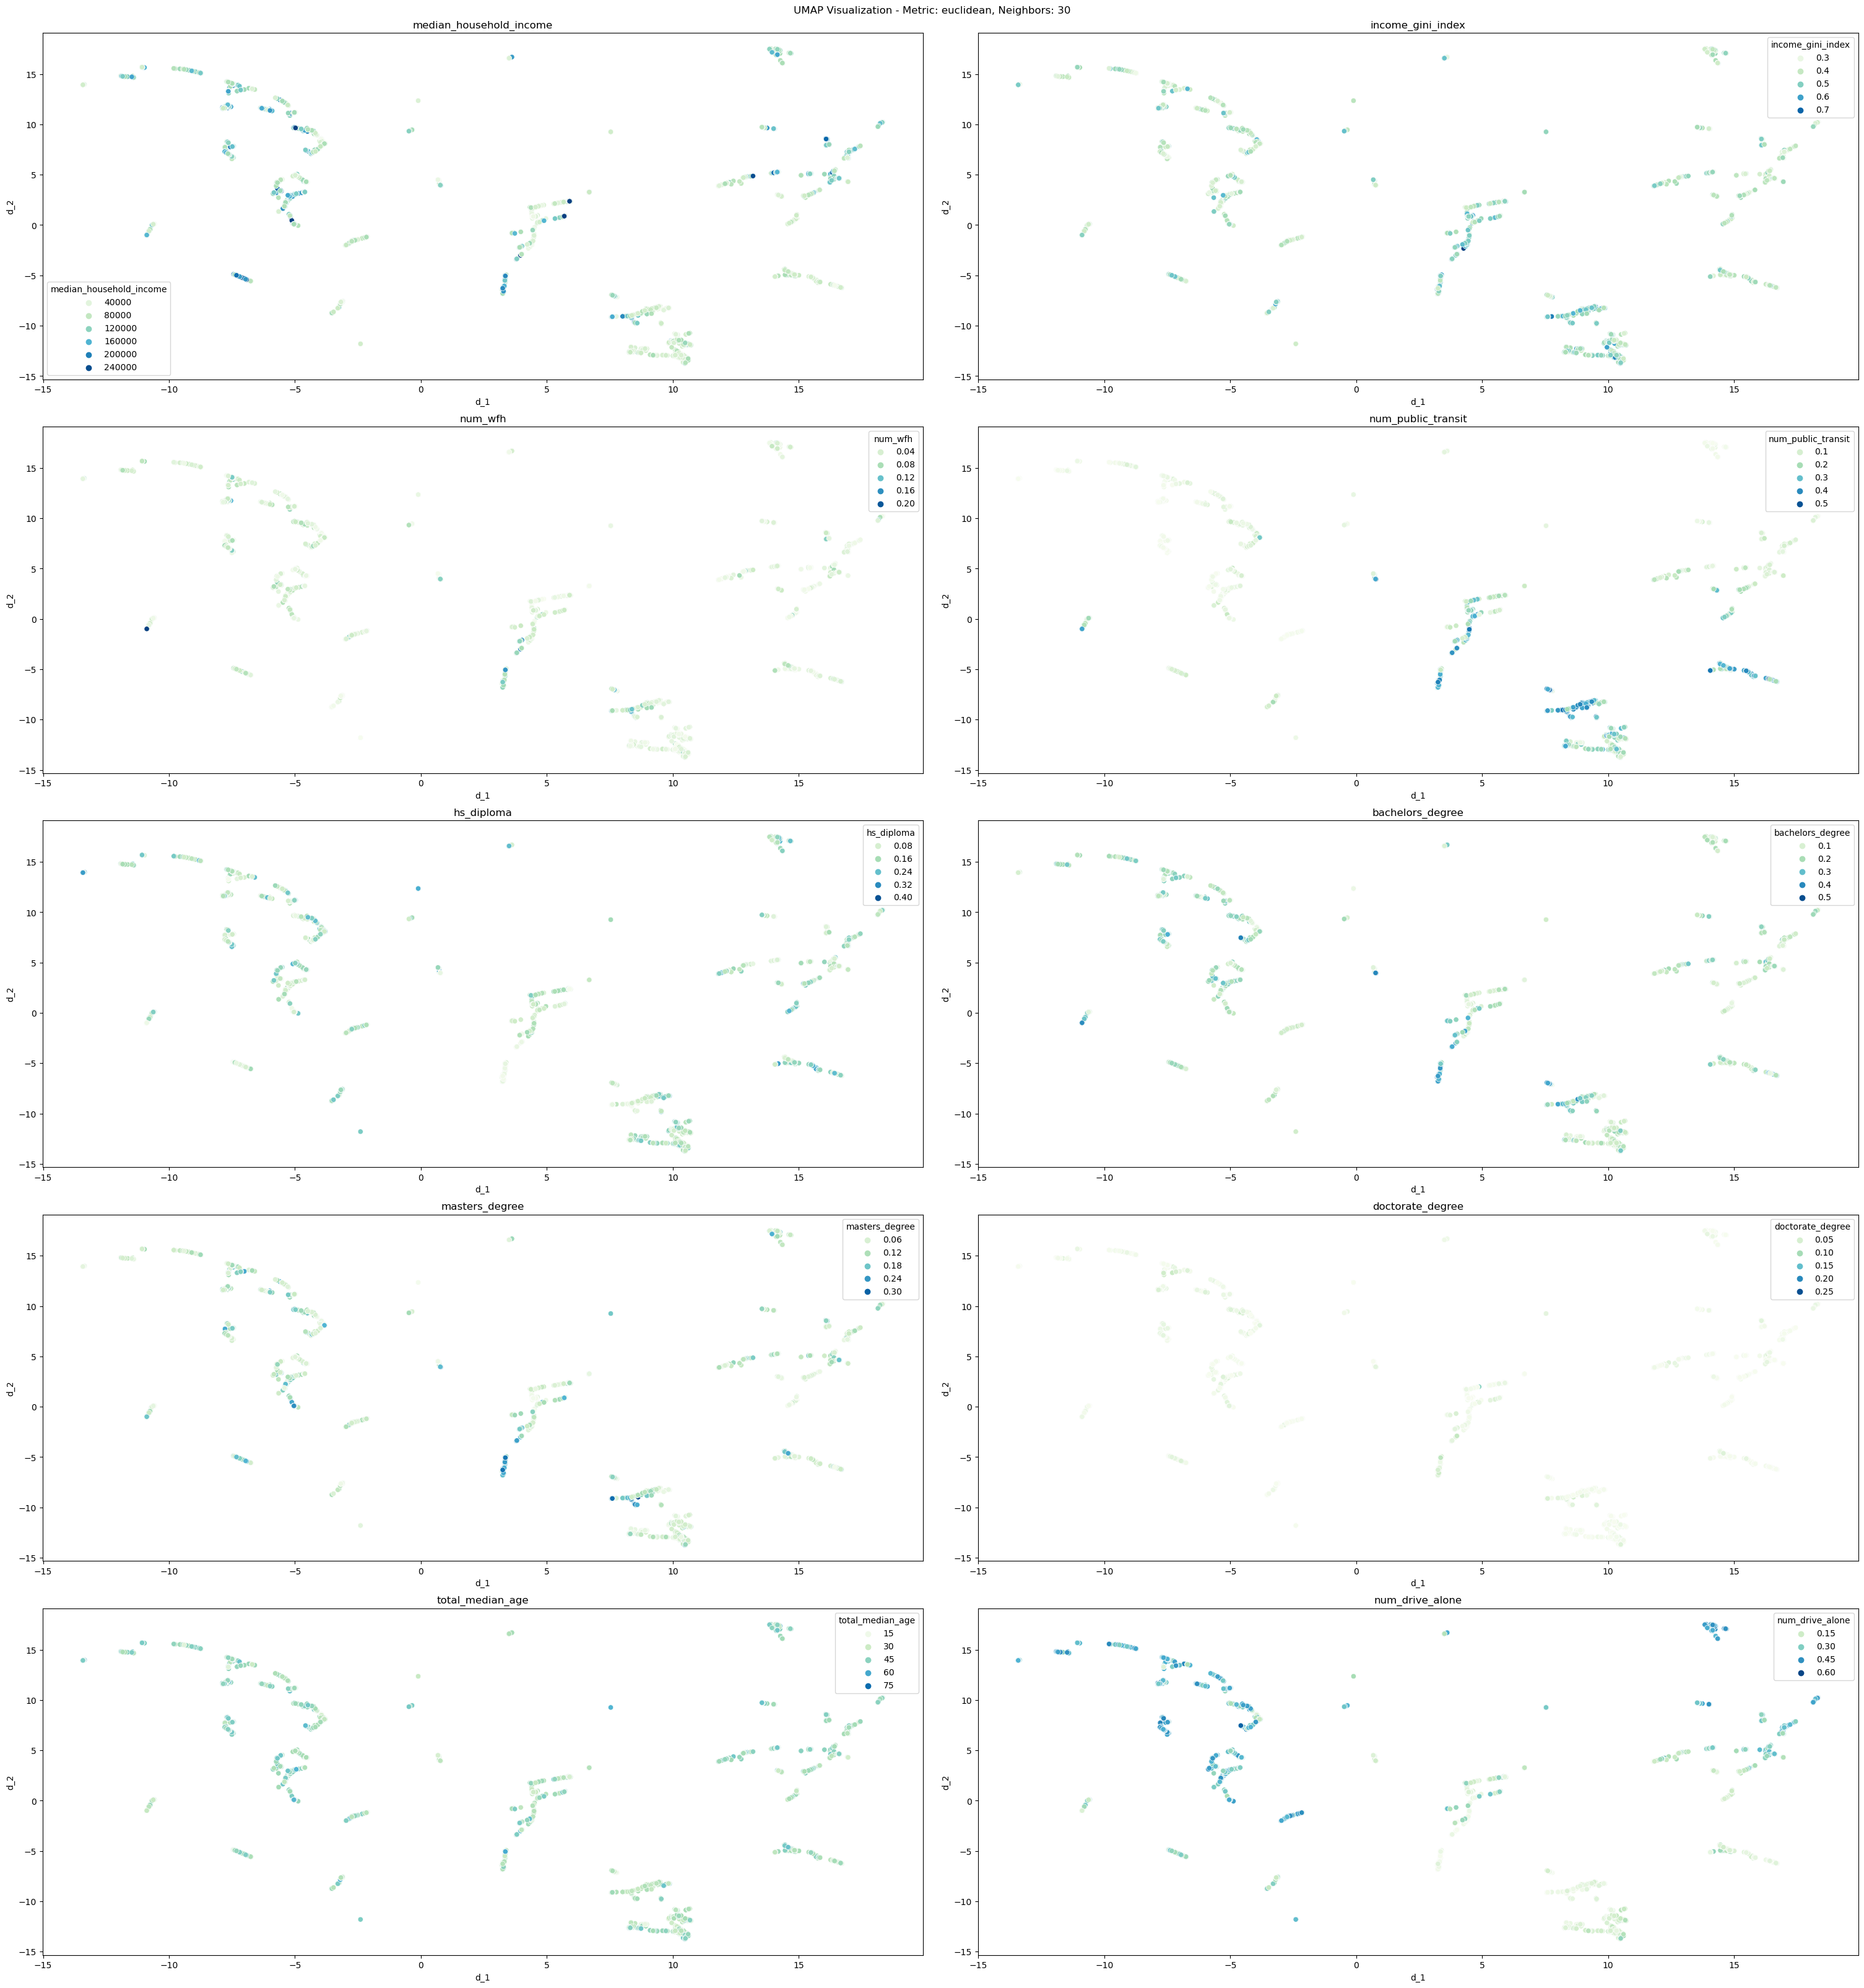

In [10]:
fig, ax = plt.subplots(5, 2, figsize=(30, 32), constrained_layout=True)
for a, col in enumerate(['median_household_income','income_gini_index', 'num_wfh', 'num_public_transit', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree', 'total_median_age', 
                       'num_drive_alone']):
    
#     valid = df.loc[df[col] > 0]
    labs, bins = pd.cut(valid[col], 5, labels=False, retbins=True)
#     y = labs
    
#     #Plot tract bins
#     valid[col+'_binned'] = labs
#     plot_list_geoids(valid['GEOID'], valid, col=col+'_binned')
#     plt.savefig(savedir + f'umap_{col}_tracts_by_bin')
    
#     plt.show()
    
    
#     # Plot col distribution
#     sns.violinplot(valid[col])
#     [plt.axhline(i, color='brown', alpha=0.5, ) for i in bins]
#     plt.title(f'{col}: BinSize~={int(bins[1]- bins[0])}')
#     plt.savefig(savedir + f'umap_{col}_distribution')
#     plt.show()
    
    for dist in [0]:
#         fig, ax = plt.subplots(3, 2, figsize=(30, 32), constrained_layout=True)
        for i, neighbors in enumerate([30]): #[10, 50]
            for j, metric in enumerate(['euclidean']):#, 'manhattan', 'cosine']):
                name = metric if type(metric) is str else metric.__name__

                reducer = umap.UMAP(n_neighbors=neighbors, min_dist=dist, n_components=2, metric=metric, random_state=42)
                Y = reducer.fit_transform(valid[[i for i in range(0, 200)]])

                result_df = pd.DataFrame({'d_1': Y[:,0], 'd_2': Y[:,1], col: valid[col]})
                
                #### For exploring UMAP params ####
#                 axis = ax[j][i]
#                 sns.scatterplot(x='d_1', y='d_2', hue=col, data=result_df, 
#                                 ax=axis, palette=plt.colormaps['GnBu'])
#                 axis.set_title(f'Neighbors={neighbors}, Metric={name}')
#                 axis.axis("tight")

                #### For plotting all variables on same figure #####
                axis = ax.flatten()[a]
                sns.scatterplot(x='d_1', y='d_2', hue=col, data=result_df, 
                                ax=axis, palette=plt.colormaps['GnBu'])
                axis.set_title(f'{col}')
                axis.axis("tight")

                            
#         plt.suptitle(f'{col}: n={valid.shape[0]}, MinDist={dist}', y=1.01)
#         plt.savefig(savedir + f'umap_{col}_{neighbors}neighbors', bbox_inches='tight')

#         plt.suptitle(f'UMAP Visualization - Metric: {name}, Neighbors: {neighbors}')
#         plt.savefig(savedir + f'umap_all_variables', bbox_inches='tight')

#         plt.show()


plt.suptitle(f'UMAP Visualization - Metric: {name}, Neighbors: {neighbors}')
plt.savefig(savedir + f'umap_all_variables', bbox_inches='tight')

plt.show()

# HDBSCAN
- Density-based clustering without assumption of uniform distributed clusters. Can create odd-shaped clusters.
- Good tutorial of clustering with UMAP: https://umap-learn.readthedocs.io/en/latest/clustering.html

In [11]:
# import hdbscan
import hdbscan
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

Text(0.5, 1.0, 'UMAP Projection for Visualization')

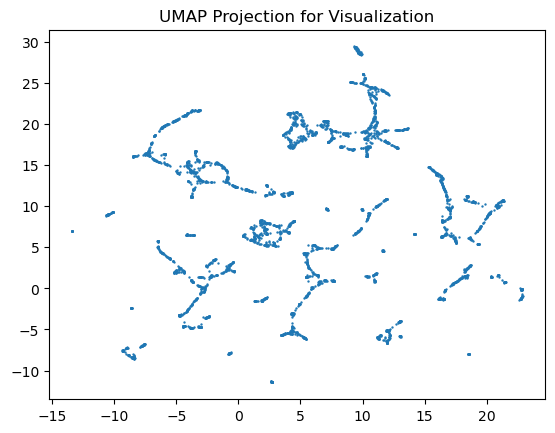

In [12]:
col = 'median_household_income'
valid = df.loc[df[col] > 0]

reducer = umap.UMAP(n_neighbors=15, min_dist=0.2, n_components=2, metric='euclidean', random_state=42)
umap_viz = reducer.fit_transform(valid[[i for i in range(0, 200)]])

plt.scatter(umap_viz[:, 0], umap_viz[:, 1],
            s=0.5);
plt.title('UMAP Projection for Visualization')

In [13]:
lowd = PCA(n_components=50).fit_transform(valid[[i for i in range(0, 200)]])
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=50).fit_predict(lowd)
(hdbscan_labels >= 0).sum()

3309

In [14]:
valid.shape

(4161, 227)

Below is the HDBSCAN labels overlayed on the UMAP embedding visualization.

Text(0.5, 1.0, 'HDBSCAN Clusters on PCA displayed on UMAP Projection')

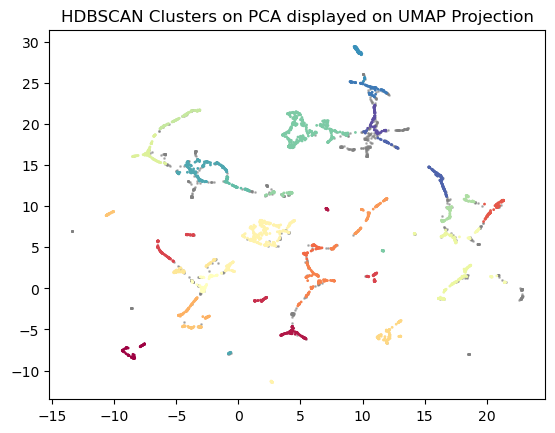

In [15]:
clustered = (hdbscan_labels >= 0)
# plt.figure(figsize=(8,8))
plt.scatter(umap_viz[~clustered, 0],
            umap_viz[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=1,
            alpha=0.5)
plt.scatter(umap_viz[clustered, 0],
            umap_viz[clustered, 1],
            c=hdbscan_labels[clustered],
            s=1,
            cmap='Spectral');
plt.title('HDBSCAN Clusters on PCA displayed on UMAP Projection')

Now, we want to use UMAP for dimensionality reduction instead of for visualization.

In [16]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0, n_components=50, metric='euclidean', random_state=42)
umap_clustering = reducer.fit_transform(valid[[i for i in range(0, 200)]])

In [17]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=50).fit_predict(umap_clustering)
(hdbscan_labels >= 0).sum()

3924

Text(0.5, 1.0, 'HDBSCAN Clusters on UMAP DR (27 clusters)')

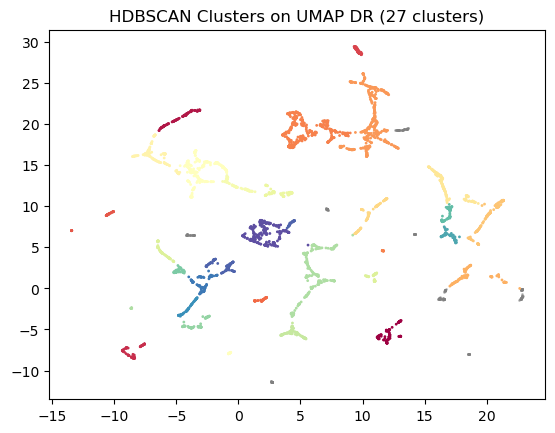

In [18]:
clustered = (hdbscan_labels >= 0)
# plt.figure(figsize=(8,8))
plt.scatter(umap_viz[~clustered, 0],
            umap_viz[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=1,
            alpha=0.5)
plt.scatter(umap_viz[clustered, 0],
            umap_viz[clustered, 1],
            c=hdbscan_labels[clustered],
            s=1,
            cmap='Spectral');

num_clusters = len(np.unique(hdbscan_labels)) - 1
plt.title(f'HDBSCAN Clusters on UMAP DR ({num_clusters} clusters)')

# Try with standardization

In [19]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()
scaled = ss.fit_transform(valid[[i for i in range(0, 200)]])

In [20]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0, n_components=50, metric='euclidean', random_state=42)
umap_clustering = reducer.fit_transform(scaled)

In [21]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=50).fit_predict(umap_clustering)
(hdbscan_labels >= 0).sum()

3823

Text(0.5, 1.0, 'HDBSCAN Clusters on UMAP DR (32 clusters)')

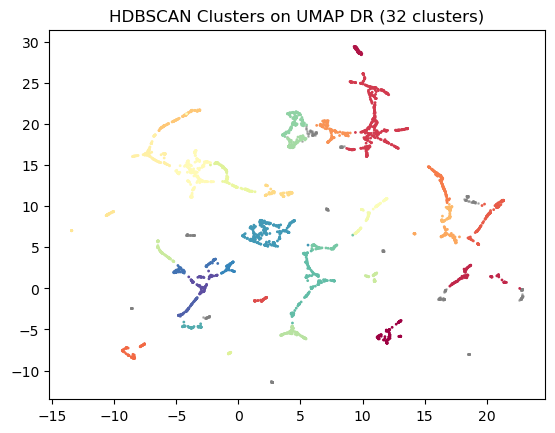

In [22]:
clustered = (hdbscan_labels >= 0)
# plt.figure(figsize=(8,8))
plt.scatter(umap_viz[~clustered, 0],
            umap_viz[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=1,
            alpha=0.5)
plt.scatter(umap_viz[clustered, 0],
            umap_viz[clustered, 1],
            c=hdbscan_labels[clustered],
            s=1,
            cmap='Spectral');

num_clusters = len(np.unique(hdbscan_labels)) - 1
plt.title(f'HDBSCAN Clusters on UMAP DR ({num_clusters} clusters)')

In [23]:
# fig, ax = plt.subplots(11, 2, figsize=(30, 45), constrained_layout=True)

# for i, col in enumerate(['median_household_income', 'income_gini_index', 'num_wfh', 'num_public_transit', 'hs_diploma', 
#                       'bachelors_degree', 'masters_degree', 'doctorate_degree', 'total_median_age', 
#                          'health_insurance_coverage', 'num_drive_alone']):
    
    
#     valid = df.loc[df[col] > 0]
#     labs, bins = pd.cut(valid[col], 5, labels=False, retbins=True)
    
#     # n_clusters value 1
#     Y = cluster.KMeans(n_clusters=3).fit_predict(valid[[i for i in range(0, 200)]])
#     result_df = pd.DataFrame({'d_1': Y[:,0], 'd_2': Y[:,1], col: valid[col]})
#     sns.scatterplot(x='d_1', y='d_2', hue=col, data=result_df, 
#                     ax=ax[i][0], palette=plt.colormaps['GnBu'])
    
    
#     # n_clusters value 2
#     Y = cluster.KMeans(n_clusters=10).fit_predict(valid[[i for i in range(0, 200)]])
#     result_df = pd.DataFrame({'d_1': Y[:,0], 'd_2': Y[:,1], col: valid[col]})
#     sns.scatterplot(x='d_1', y='d_2', hue=col, data=result_df, 
#                     ax=ax[i][1], palette=plt.colormaps['GnBu'])

# Qualitative Analysis of Embedding Space

We expect to see closer tracts (in terms of distance or mobility) have representations closer in the embedding space. As distance increases, we expect the embeddings to be further.

If we observe this for both distance and mobility, this indicates that the model learned both spatial and mobility relationships.

In [24]:
# load model embeddings

# add GEOID column to embeddings df
df = pd.DataFrame(checkpoint['model_state_dict']['node_embeddings.weight'].cpu())

In [25]:
from sklearn.metrics.pairwise import euclidean_distances

In [26]:
scenario

'all_valid_data/'

In [27]:
# Load distances
# #### DISTANCE #####
# scenario = 'all_valid_data/'
path = f'/mnt/e/julia/regional-representations-graph-model/dataset/preprocessed_data/{scenario}'

with open(path+'distance_node_idx_map.pkl', 'rb') as f:
    d1 = pickle.load(f)
with open(path+'distance_idx_node_map.pkl', 'rb') as f:
    d2 = pickle.load(f)
with open(path + 'distance_edge_matrix.pkl', 'rb') as f:
    data = pickle.load(f)
    
datasets1 = DistanceDataset(node_list_path=node_list_path, is_train=True, threshold=None, data=data, node_idx_mapping=d1, idx_node_mapping=d2)

Num Nodes: 4599
[[    0.          5003.82370953  3691.23681912  4039.39242393
  20129.350942  ]
 [ 5003.82370953     0.          1314.67475189  2621.37062805
  16228.95227057]
 [ 3691.23681912  1314.67475189     0.          2185.42552337
  17239.10363665]
 [ 4039.39242393  2621.37062805  2185.42552337     0.
  16095.2487974 ]
 [20129.350942   16228.95227057 17239.10363665 16095.2487974
      0.        ]]


In [28]:
from math import perm
print(f'Number of permutation pairs: {perm(num_nodes, 2)}')
print('M3G reports this number, for some reason...')

Number of permutation pairs: 21146202
M3G reports this number, for some reason...


In [29]:
from math import comb
print(f'Number of unique pairs: {comb(num_nodes, 2)}')
print(f'1% is {comb(num_nodes, 2)*0.1}')

Number of unique pairs: 10573101
1% is 1057310.1


In [30]:
# mobility data
graph_path = root + 'dataset/safegraph/graph_checkpoints/nyc_metro/checkpoint_12.pkl'
with open(graph_path, 'rb') as f:
    g = pickle.load(f)

In [31]:
import itertools

geoids = np.array(list(d1.keys()))
combos = list(itertools.combinations(geoids,2))

In [33]:
import random
from sklearn.decomposition import PCA
import umap

pca=PCA(n_components=2)
umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0, n_components=2, metric='euclidean', random_state=42)
    
# sample x% of 10 million pairs of census tracts
sampled_pairs = random.choices(combos, k=20000)

# get embeddings from model
embeddings = np.array([(df.iloc[node_idx_map[pair[0]]], df.iloc[node_idx_map[pair[1]]]) for pair in sampled_pairs])

# get spatial distance from matrix
spatial_distance = [data[d1[pair[0]]][d1[pair[1]]]/1000 for pair in sampled_pairs]

# or mobility
def get_mobility(a, b):
    return g.edge_mat[g.node_idx_map[a]][g.node_idx_map[b]]

mobility_distance = [get_mobility(pair[0], pair[1]) + get_mobility(pair[1], pair[0]) for pair in sampled_pairs]

In [34]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()

In [35]:
# list of all embeddings to fit dim reducer models
e1 = embeddings[:, 0, :]
e2 = embeddings[:, 1, :]

In [36]:
# standardize for PCA
train = np.concatenate([e1, e2])
ss.fit(train)
e1_scaled = ss.transform(e1)
e2_scaled = ss.transform(e2)

train = np.concatenate([e1_scaled, e2_scaled])
pca.fit(train)

# reduce dimensions to 2 (method 1: PCA, method2: UMAP)
red_pca0 = pca.transform(e1_scaled)
red_pca1 = pca.transform(e2_scaled)

In [ ]:
# don't standardize for umap does
train = np.concatenate([e1, e2])
umap_reducer.fit(train)
red_umap0 = umap_reducer.transform(e1)
red_umap1 = umap_reducer.transform(e2) 

In [199]:
pca_dist_list = []
umap_dist_list = []
for i in range(0, red_pca0.shape[0]):
    x = red_pca0[i,:]
    y = red_pca1[i,:]

    pca_dist = euclidean_distances(x.reshape(1, -1), y.reshape(1, -1))[0][0]
    pca_dist_list.append(pca_dist)
    
    x = red_umap0[i,:]
    y = red_umap1[i,:]
    umap_dist = euclidean_distances(x.reshape(1, -1), y.reshape(1, -1))[0][0]
    umap_dist_list.append(umap_dist)

In [193]:
from scipy import stats

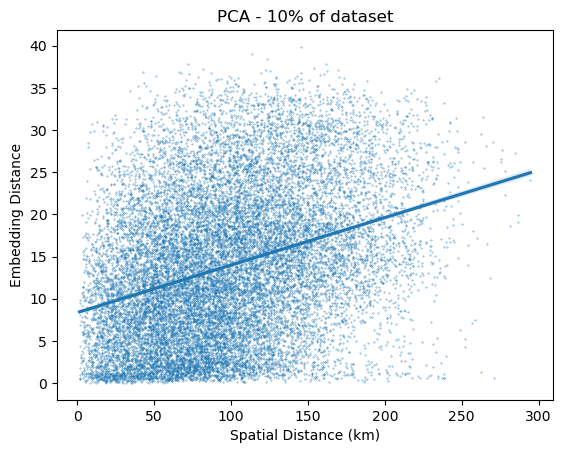

In [204]:
df_plot = pd.DataFrame(zip(spatial_distance, pca_dist_list), columns=['distance', 'pca'])
slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['distance'],df_plot['pca'])
g = sns.regplot(
    data=df_plot,
    x="distance", y="pca",
    scatter_kws={"s": 0.1},
    line_kws={'label':"y={0:.3f}x+{1:.1f}".format(slope,intercept)}
)

plt.title(f'PCA - 10% of dataset')
plt.xlabel('Spatial Distance (km)')
plt.ylabel('Embedding Distance')
plt.savefig(root + 'train/outputs/' + scenario + 'pca_distance_scatterplot')

/tmp/ipykernel_1043114/2364535963.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(mobility_distance), 5000)


(2.511403270602251, 5000)

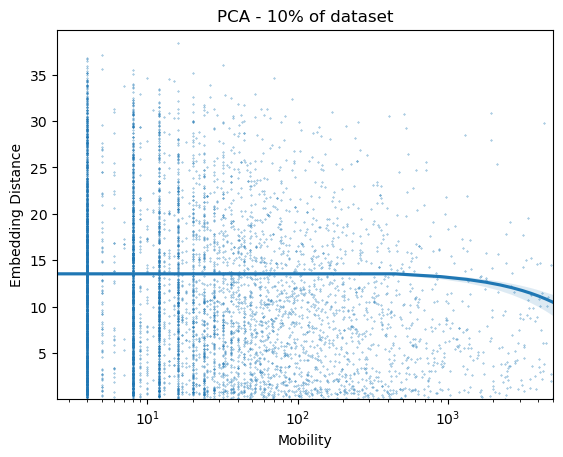

In [280]:
df_plot = pd.DataFrame(zip(mobility_distance, pca_dist_list), columns=['distance', 'pca'])
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['distance'],df_plot['pca'])
g = sns.regplot(
    data=df_plot,
    x="distance", y="pca",
    scatter_kws={"s": 0.1},
    
)
plt.xscale("log")
plt.title(f'PCA - 10% of dataset')
plt.xlabel('Mobility')
plt.ylabel('Embedding Distance')
plt.ylim(min(pca_dist_list), max(pca_dist_list))
plt.xlim(min(mobility_distance), 5000)
# plt.savefig(root + 'train/outputs/' + scenario + 'pca_distance_scatterplot')

(0.025990553200244904, 39.85173797607422)

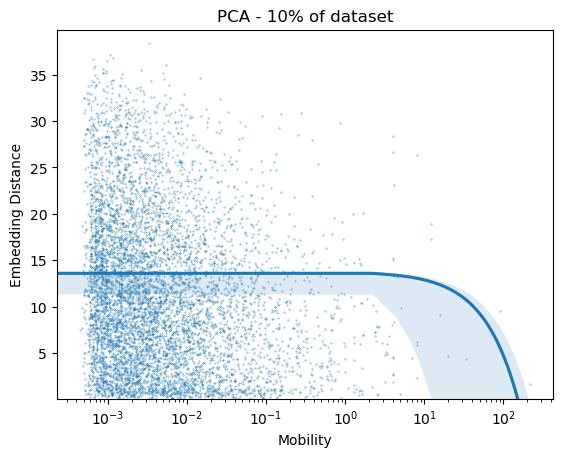

In [272]:
df_plot = pd.DataFrame(zip(mobility_distance, pca_dist_list), columns=['distance', 'pca'])
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['distance'],df_plot['pca'])
g = sns.regplot(
    data=df_plot,
    x="distance", y="pca",
    scatter_kws={"s": 0.1},
    
)
plt.xscale("log")
plt.title(f'PCA - 10% of dataset')
plt.xlabel('Mobility')
plt.ylabel('Embedding Distance')
plt.ylim(min(pca_dist_list), max(pca_dist_list))
# plt.savefig(root + 'train/outputs/' + scenario + 'pca_distance_scatterplot')

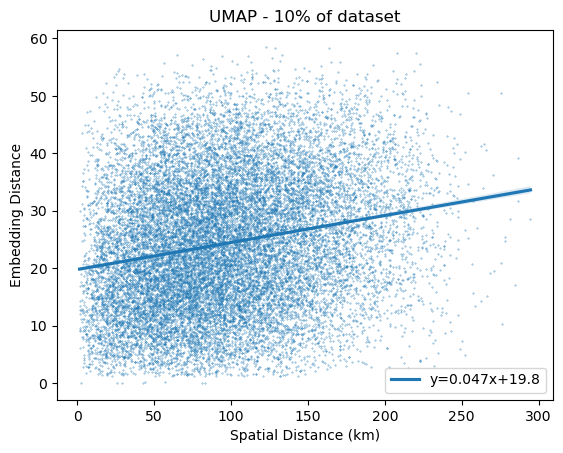

In [205]:
df_plot = pd.DataFrame(zip(spatial_distance, umap_dist_list), columns=['distance', 'umap'])
slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['distance'],df_plot['umap'])


g = sns.regplot(
    data=df_plot,
    x="distance", y="umap",
    scatter_kws={"s": 0.1},
    line_kws={'label':"y={0:.3f}x+{1:.1f}".format(slope,intercept)}
)
g.legend()
plt.title('UMAP - 10% of dataset')
plt.xlabel('Spatial Distance (km)')
plt.ylabel('Embedding Distance')
plt.savefig(root + 'train/outputs/' + scenario + 'umap_distance_scatterplot')

# 

In [197]:
# Plot PCA

In [196]:
df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.006658,-0.078286,-0.061112,0.098270,-0.041801,-0.009406,-0.026049,-0.053071,0.011268,0.089375,...,-0.040533,-0.123913,0.074500,0.084773,0.051219,0.063937,0.022386,-0.083646,0.027519,0.045853
1,-0.003917,-0.082207,-0.064932,0.101842,-0.040258,-0.020371,-0.034420,-0.050427,0.016708,0.082172,...,-0.043404,-0.122262,0.076625,0.090601,0.047640,0.066607,0.031189,-0.083975,0.032596,0.055418
2,-0.004798,-0.077275,-0.061232,0.098909,-0.031397,-0.014509,-0.023102,-0.050063,0.014250,0.078230,...,-0.042257,-0.118907,0.068628,0.082237,0.051624,0.060587,0.021361,-0.088978,0.033130,0.050883
3,-0.000014,-0.081929,-0.069921,0.104882,-0.035645,-0.011700,-0.025251,-0.057765,0.023898,0.087889,...,-0.040526,-0.121314,0.077552,0.087194,0.043478,0.063061,0.036961,-0.086663,0.031786,0.043566
4,-0.000049,-0.075579,-0.063439,0.099284,-0.038164,-0.018517,-0.020692,-0.049468,0.021118,0.085514,...,-0.044833,-0.120959,0.077342,0.084174,0.059434,0.064128,0.029614,-0.086829,0.036732,0.051759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,-0.011974,-0.021288,0.006856,-0.006232,-0.042784,0.007123,0.002320,-0.066231,0.030583,0.016703,...,0.005151,-0.017920,-0.035492,-0.006659,0.021921,0.001162,0.033261,-0.007066,0.039867,-0.008195
1146,0.030138,-0.014458,0.040341,-0.056280,-0.005659,-0.015641,0.022671,-0.045478,-0.016567,-0.008306,...,-0.009558,-0.028323,-0.034099,-0.013283,-0.009804,-0.023351,-0.042704,-0.020957,0.030564,-0.000969
1147,-0.030950,-0.039087,-0.031035,-0.025522,-0.017999,-0.035264,-0.006117,-0.052532,0.053703,0.002484,...,0.009827,-0.025858,-0.002203,-0.018626,0.015649,0.004902,0.002005,-0.036804,0.019517,0.034168
1148,-0.016722,-0.019049,-0.008164,-0.010444,-0.026142,-0.003341,-0.001190,-0.037255,0.021886,0.025393,...,0.016801,0.009426,-0.028318,-0.014285,-0.008680,-0.000683,-0.020536,-0.036191,-0.004787,0.007906


In [ ]:
sns.scatterplot()